In [1]:
import torch
import torch.backends.cudnn as cudnn
import torchvision
import cv2 
from matplotlib import pyplot as plt
import os
import numpy as np
import PIL
import random
from PIL import Image
import h5py
from typing import Generator
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "2"  # Set the GPU 1 to use
from core.data_loader import sem_generator,patch_generator, load_whole_image
from core.crop_image import scale_f_num_0to3,crop_image, make_image_crop
from core.utils import seed_everything

/mnt/ssd/hyun/fbi-net/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
seed_everything(0) # Seed 고정

In [7]:
# load whole image[size : (2048, 3072)] in "whole_images" 
data_path = "Samsung_SNU"
num_per_Ffolder = 16
# whole_images = load_whole_image(data_path,num_per_Ffolder)

In [8]:
gen = sem_generator(data_path)

In [9]:
def generate_top_bottom_crop_image(data_path : str,generator : Generator[str,str,np.array]):
    for img in generator:
        set_num, f_num, image_num = img[:3]
        save_dir = os.path.join(data_path+"_1536x3072",set_num)
        os.makedirs(save_dir,exist_ok=True)
        #print(save_dir)
        img = img[-1][256:-256,:]
        #plt.imshow(img,cmap='gray')
        file_name = f"{f_num}_{image_num}.png"
        file_path = os.path.join(save_dir,file_name)
        plt.imsave(file_path,img,cmap='gray')

In [10]:
#generate_top_bottom_crop_image(data_path,gen)

In [11]:
!ls Samsung_SNU_1536x3072/SET1/F16_1.png

Samsung_SNU_1536x3072/SET1/F16_1.png


In [2]:
data_path="./Samsung_SNU_1536x3072"
crop_data_path="./Samsung_SNU_cropped"
os.makedirs(crop_data_path,exist_ok=True)
random_crop = torchvision.transforms.RandomCrop(size=256)
crop_size = 256
num_crop= 20 #500

def show_patch(crop_im):
    crop_im = crop_im.permute(1,2,0).cpu().numpy()
    crop_im = crop_im.astype('uint8')
    PIL.Image.fromarray(crop_im)
def read_image_and_crop(image : np.array, target : np.array):
    im_t,target_im_t = torch.Tensor(image).cuda(), torch.Tensor(target).cuda()
    top = random.randrange(0,image.shape[0]-crop_size)
    left = random.randrange(0,image.shape[1]-crop_size)
    crop_im = torchvision.transforms.functional.crop(im_t,top,left,crop_size,crop_size)
    crop_target_im = torchvision.transforms.functional.crop(target_im_t,top,left,crop_size,crop_size)
    
    return crop_im,crop_target_im

In [3]:
gen1 = patch_generator(data_path)
for im in gen1:
    print(im)
    break

['SET1', 'F16', '1.png', array([[ 85,  87, 120, ...,  62,  75,  29],
       [ 85, 133,  80, ...,  55,  64,  55],
       [ 73,  39, 107, ...,  99, 110,  94],
       ...,
       [ 95, 104,  58, ..., 102, 136, 119],
       [125, 125, 133, ...,  81,  81,  44],
       [ 55,  73,  56, ...,  78,  35,  68]], dtype=uint8)]


In [14]:
import h5py

In [4]:

for set_num in sorted(os.listdir(data_path)):
    print(set_num)
    set_path = os.path.join(data_path,set_num)
    image_list = sorted(os.listdir(set_path)) # 16
    image_list = list(filter(lambda x : "F64" not in x,image_list))
    image_list = list(filter(lambda x : "checkpoints" not in x,image_list))
    noisy_patch = torch.Tensor(num_crop*len(image_list),256,256).cuda() 
    target_patch = torch.Tensor(num_crop*len(image_list),256,256).cuda()
    print(len(image_list))
    for image_idx,image_name in enumerate(image_list):
        image_path = os.path.join(data_path,set_num,image_name)
        image_num = image_name.split("_")[1]
        clean_path = os.path.join(data_path,set_num,f"F64_{image_num}")
        im = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
        target_im = cv2.imread(clean_path,cv2.IMREAD_GRAYSCALE)
        patch_save_path = os.path.join(crop_data_path,set_num,image_name)
        
        for i in range(num_crop):
            im_cropped,target_im_cropped = read_image_and_crop(im,target_im)
            #print(im_cropped.shape)
            index = i + image_idx*num_crop
            noisy_patch[i],target_patch[i] = im_cropped,target_im_cropped
            #print(im_cropped.shape)
    print(noisy_patch.shape,target_patch.shape)
    break

SET1
48
torch.Size([960, 256, 256]) torch.Size([960, 256, 256])


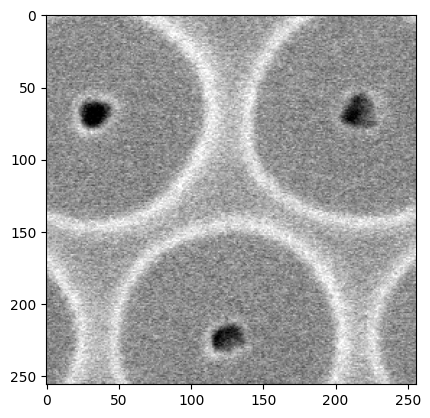

In [149]:
plt.imshow(target_patch.cpu()[0],cmap='gray')

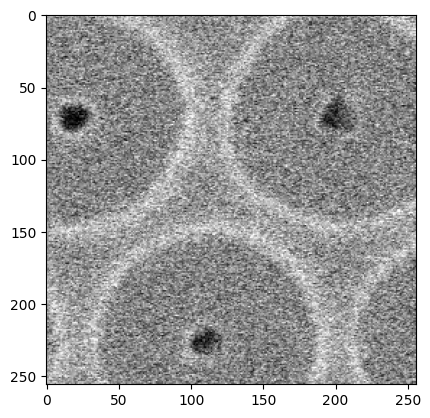

In [150]:
plt.imshow(noisy_patch.cpu()[0],cmap='gray')

NameError: name 'noisy_path' is not defined